In [2]:
import warnings
import logging
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=RuntimeWarning)
logging.getLogger("dowhy").setLevel(logging.WARNING)
logging.getLogger("pgmpy").setLevel(logging.WARNING)

import tqdm
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import statsmodels.api as sm
from IPython.display import display
from causaldata import social_insure
from pgmpy.estimators.CITests import pillai_trace


df: pd.DataFrame = social_insure.load_pandas().data.dropna()

In [3]:
# Drop fields 'address'
df = df.drop(columns=['address'])

# From social insurance, take takeup_survey
takeup_survey = df['takeup_survey']

## Convert labels to categorical variables

In [4]:
categorical_variables = ['village']
for var in categorical_variables:
    df[var] = df[var].astype('category').cat.codes


# 2.1 Testing correlation / dependence between variables

In [5]:
# For each other variable, calculate the p value of the correlation with takeup_survey
graph1: dict[str, dict[str, bool]] = {}

# Double for loop to compute pillai_trace between each pair of columns
for col1 in tqdm.tqdm(df.columns):
    graph1[col1] = {}
    for col2 in df.columns:
        if col1 == col2:
            continue
        graph1[col1][col2] = pillai_trace(col1, col2, Z=[], data=df, significance_level=0.05)


100%|██████████| 12/12 [00:02<00:00,  4.16it/s]


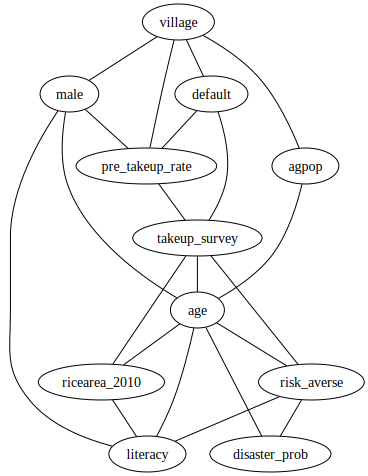

In [6]:
# Create a graph from the p values
G1 = nx.Graph()
for col1 in graph1:
    for col2 in graph1[col1]:
        p_value = graph1[col1][col2]
        if not p_value:
            G1.add_edge(col1, col2)


A = nx.nx_agraph.to_agraph(G1)
A.layout('dot')
A

As can be seen in the above image, the causal links calculated make sense. For example,
 - `age` and `disaster probability` have in no way any correlation.
 - `village` and `male` are uncorrelated.

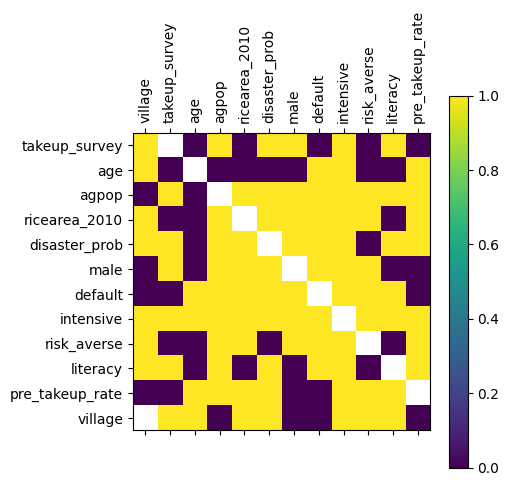

In [7]:
df_confusion_matrix = pd.DataFrame(graph1)
plt.matshow(df_confusion_matrix.replace({True: 1, False: 0}))
plt.xticks(range(len(df_confusion_matrix.columns)), df_confusion_matrix.columns, rotation=90)
plt.yticks(range(len(df_confusion_matrix.index)), df_confusion_matrix.index)
plt.colorbar()
plt.show()

True (1) means indepedent, False (0) means not indepedent

# 2.2 Casual graph
As the true causal graph is unknown, we cooked something up which made sense.

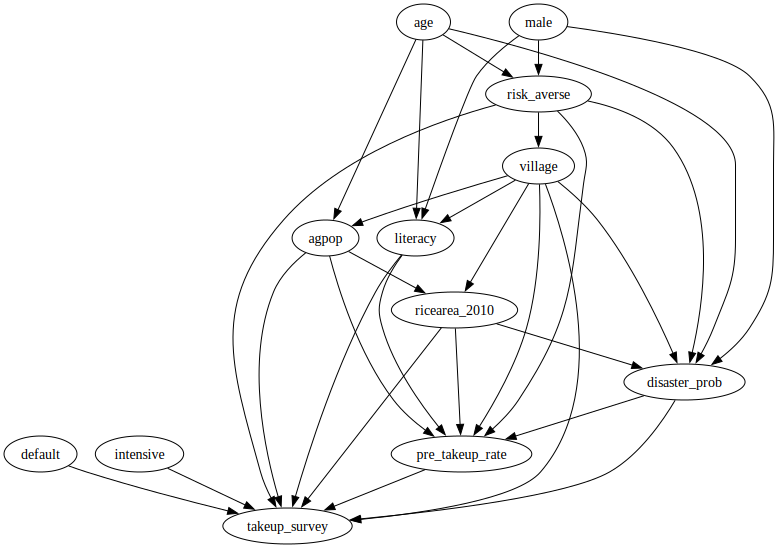

In [8]:
TG = nx.DiGraph()
TG.add_edges_from([
    ('default', 'takeup_survey'),

    ('intensive', 'takeup_survey'),

    ('pre_takeup_rate', 'takeup_survey'),

    ('risk_averse', 'pre_takeup_rate'),
    ('risk_averse', 'takeup_survey'),
    ('risk_averse', 'village'),
    ("risk_averse", "disaster_prob"), # disaster prob is perceived,

    ('disaster_prob', 'pre_takeup_rate'),
    ('disaster_prob', 'takeup_survey'),

    ('literacy', 'pre_takeup_rate'),
    ('literacy', 'takeup_survey'),

    ('village', 'pre_takeup_rate'),
    ('village', 'takeup_survey'),
    ('village', 'literacy'),
    ('village', 'ricearea_2010'),
    ('village', 'disaster_prob'),
    ("village", "agpop"), # certain villages might expect larger families

    ('age', 'agpop'),
    ("age", "literacy"), # older people -> less education (?)
    ("age", "risk_averse"), # older people more risk averse
    ("age", "disaster_prob"), # disaster prob is perceived, so older -> better intuition


    ("agpop", "ricearea_2010"), # larger homes -> more land
    ("agpop", "takeup_survey"), # more security wanted because of family size
    ("agpop", "pre_takeup_rate"), # same as previous

    ("male", "literacy"), # gender gaps in education
    ("male", "risk_averse"), # gender differences in risk attitudes
    ("male", "disaster_prob"), # disaster prob is perceived,

    ("ricearea_2010", "disaster_prob"), # more land -> more chances for disaster
    ("ricearea_2010", "takeup_survey"), # more land -> more at stake
    ("ricearea_2010", "pre_takeup_rate"), # same as previous
    ('ricearea_2010', 'takeup_survey'),
])

A = nx.nx_agraph.to_agraph(TG)
A.layout('dot')
display(A)

# 3. Backdoor, Frontdoor and Instrumental Variables Criteria

In [9]:
from dowhy.causal_identifier import identify_effect
from dowhy import CausalModel


model = CausalModel(
    data=df,
    treatment='risk_averse',
    outcome='takeup_survey',
    graph=TG,
)
print(model.identify_effect())

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                 
─────────────(E[takeup_survey|age,male])
d[riskₐᵥₑᵣₛₑ]                           
Estimand assumption 1, Unconfoundedness: If U→{risk_averse} and U→takeup_survey then P(takeup_survey|risk_averse,age,male,U) = P(takeup_survey|risk_averse,age,male)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

### Estimand : 4
Estimand name: general_adjustment
Estimand expression:
      d                                 
─────────────(E[takeup_survey|age,male])
d[riskₐᵥₑᵣₛₑ]                           
Estimand assumption 1, Unconfoundedness: If U→{risk_averse} and U→takeup_survey then P(takeup_survey|risk_averse,age,male,U) = P(takeup_survey|risk_averse,age,male)



### Conclusions
For the backdoor we condition on Z = {age, male} to find the causal effect of risk_averse on takeup_survey.

There is no frontdoor criterion and no IV either. More details explanation can be found: https://chatgpt.com/share/69297e5a-f860-8008-b9e3-077090a23451

# 4. Estimating Causal Effects
Probably want linear + logistic regression for this, not inverse propensity weighting, two-stage linear regression because for ipw: risk_averse is not binary, no tslr: because no IV instrument

In [10]:
estimate = model.estimate_effect(model.identify_effect(), method_name="backdoor.linear_regression", test_significance=True)
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                 
─────────────(E[takeup_survey|age,male])
d[riskₐᵥₑᵣₛₑ]                           
Estimand assumption 1, Unconfoundedness: If U→{risk_averse} and U→takeup_survey then P(takeup_survey|risk_averse,age,male,U) = P(takeup_survey|risk_averse,age,male)

## Realized estimand
b: takeup_survey~risk_averse+age+male+risk_averse*intensive+risk_averse*default
Target units: 

## Estimate
Mean value: 0.2229288956825206
p-value: [0.02820068]
### Conditional Estimates
__categorical__intensive  __categorical__default
(-0.001, 1.0]             (-0.001, 1.0]             0.222929
dtype: float64


In [11]:
estimate = model.estimate_effect(
    model.identify_effect(),
    method_name="backdoor.generalized_linear_model",
    test_significance=True,
    method_params = {
        'fit_method': "statsmodels",
        'glm_family': sm.families.Binomial(), # logistic regression
        'need_conditional_estimates':False
    }
)
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                 
─────────────(E[takeup_survey|age,male])
d[riskₐᵥₑᵣₛₑ]                           
Estimand assumption 1, Unconfoundedness: If U→{risk_averse} and U→takeup_survey then P(takeup_survey|risk_averse,age,male,U) = P(takeup_survey|risk_averse,age,male)

## Realized estimand
b: takeup_survey~Sigmoid(risk_averse+age+male+risk_averse*intensive+risk_averse*default)
Target units: ate

## Estimate
Mean value: 0.21880717790545406
p-value: [0, 0.001]



## PC
Implementation of the PC algorithm for causal discovery using the `pgmpy` library. We will also define some extra background knowledge to guide the algorithm and improve performance.

In [12]:
from pgmpy.estimators import PC, ExpertKnowledge

pc_calc = PC(data=df.copy())
forbidden_edges = [
]
required_edges = [
    ('takeup_survey', 'risk_averse'),
]

expert_knowledge = ExpertKnowledge(
    forbidden_edges=forbidden_edges,
    required_edges=required_edges,
)

#### Draw the graph obtained with PC algorithm + background knowledge    

In [ ]:
supported_tests = [
    "chi_square",
    "g_sq",
    "log_likelihood",
    "modified_log_likelihood",
    "pearsonr",
    "gcm",
    pillai_trace,
]

for ci_test in supported_tests:
    print(f"Using CI test: {ci_test}")

    pc_graph = pc_calc.estimate(
        ci_test=ci_test,
        # ci_test=pillai_trace,
        # ci_test="pearsonr",
        return_type="cpdag",
        significance_level=0.05,
        expert_knowledge=expert_knowledge,
        enforce_expert_knowledge=True,
    )
    print("Done")

    A = nx.nx_agraph.to_agraph(pc_graph)
    A.layout('dot')
    display(A)


In [ ]:
from pgmpy.estimators import GES

supported_methods = [
    "k2",
    "bdeu",
    "bds",
    "bic-d",
    "aic-d",
    "ll-g",
    "aic-g",
    "bic-g",
    "ll-cg",
    "aic-cg",
    "bic-cg",
]

for method in supported_methods:
    print(f"Estimating GES with scoring method: {method}")
    ges_graph_pgmpy = GES(df.copy()).estimate(scoring_method=method, expert_knowledge=expert_knowledge)

    A = nx.nx_agraph.to_agraph(ges_graph_pgmpy)
    A.layout('dot')
    display(A)

# VALIDATION AND SENSITIVITY ANALYSIS
Report using some of the results of the refutation strategies implemented in DoWhy and interpret what they mean

In [19]:
estimand = model.identify_effect()


In [20]:
refute_random = model.refute_estimate(
    estimand,
    estimate,
    method_name="random_common_cause"
)
print(refute_random)

Refute: Add a random common cause
Estimated effect:0.21880717790545406
New effect:0.21880717790545404
p value:1.0



Adding a completely random “fake confounder” to the model does not change the estimated effect of risk aversion on insurance take-up at all. The estimate is extremely stable to this perturbation, and the p-value of 1.0 indicates no evidence that the added noise has any impact.

In [22]:
refute_subset = model.refute_estimate(
    estimand,
    estimate,
    method_name="data_subset_refuter",
    subset_fraction=0.8,      # use 80% of the data each time
    num_simulations=100       # how many random subsets
)
print(refute_subset)

Refute: Use a subset of data
Estimated effect:0.21880717790545406
New effect:0.21720951593601698
p value:0.96



When we repeatedly re-estimate the effect of risk aversion on take-up using only 80% of the data, the average estimated effect is ~0.220, extremely close to the original 0.219. The high p-value (~0.92) indicates that the difference is not statistically meaningful; the effect is stable across subsamples and not driven by a small subset of observations.

### If your dataset includes interventional data, check that the estimated causal effects from the observational data are reflected in the interventional data

In [24]:
model_default = CausalModel(
    data=df,
    treatment='default',
    outcome='takeup_survey',
    graph=TG  # a DAG where default has no parents (randomized)
)

estimand_default = model_default.identify_effect()
estimate_default = model_default.estimate_effect(
    estimand_default,
    method_name="backdoor.linear_regression",  # or logistic GLM
    test_significance=True
)
print(estimate_default)

import statsmodels.api as sm
import statsmodels.formula.api as smf

logit_default = smf.logit("takeup_survey ~ default", data=df).fit()
print(logit_default.summary())
# You can compute predicted probabilities at default=0 and default=1 and take the difference.



*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                       
──────────(E[takeup_survey])
d[default]                  
Estimand assumption 1, Unconfoundedness: If U→{default} and U→takeup_survey then P(takeup_survey|default,,U) = P(takeup_survey|default,)

## Realized estimand
b: takeup_survey~default+default*pre_takeup_rate+default*ricearea_2010+default*intensive+default*disaster_prob+default*agpop+default*risk_averse+default*age+default*literacy+default*village+default*male
Target units: 

## Estimate
Mean value: 0.0601687444268858
p-value: [1.41467657e-05]
### Conditional Estimates
__categorical__pre_takeup_rate  __categorical__ricearea_2010  __categorical__intensive  __categorical__disaster_prob  __categorical__agpop  __categorical__risk_averse  __categorical__age  __categorical__literacy  __categorical__village  __categorical__male
(-0.001, 0.2]             

ATE: Effect size ≈ 0.06 → going from default = 0 to default = 1
increases the probability of take-up by about 6 percentage points on average. highly significant.

Logistics: Going from default = 0 to 1 increases take-up by ~9–10 p.p., also highly significant.

In [25]:
model_default = CausalModel(
    data=df,
    treatment='intensive',
    outcome='takeup_survey',
    graph=TG  # a DAG where default has no parents (randomized)
)

estimand_default = model_default.identify_effect()
estimate_default = model_default.estimate_effect(
    estimand_default,
    method_name="backdoor.linear_regression",  # or logistic GLM
    test_significance=True
)
print(estimate_default)

import statsmodels.api as sm
import statsmodels.formula.api as smf

logit_default = smf.logit("takeup_survey ~ intensive", data=df).fit()
print(logit_default.summary())
# You can compute predicted probabilities at default=0 and default=1 and take the difference.



*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                        
────────────(E[takeup_survey])
d[intensive]                  
Estimand assumption 1, Unconfoundedness: If U→{intensive} and U→takeup_survey then P(takeup_survey|intensive,,U) = P(takeup_survey|intensive,)

## Realized estimand
b: takeup_survey~intensive+intensive*pre_takeup_rate+intensive*ricearea_2010+intensive*default+intensive*disaster_prob+intensive*agpop+intensive*risk_averse+intensive*age+intensive*literacy+intensive*village+intensive*male
Target units: 

## Estimate
Mean value: -0.0067206667911490214
p-value: [2.1559021e-06]
### Conditional Estimates
__categorical__pre_takeup_rate  __categorical__ricearea_2010  __categorical__default  __categorical__disaster_prob  __categorical__agpop  __categorical__risk_averse  __categorical__age  __categorical__literacy  __categorical__village  __categorical

Effect size ≈ −0.0067 → about −0.7 percentage points.
So the intensive information treatment slightly reduces take-up on average, but very, very slightly. statistically significant.
